In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import IPython.display as ipd

import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [3]:
df

,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,ARTIST_location,ARTIST_tags,ARTIST_name,TRACK_duration,TRACK_favorites,TRACK_genre_top,TRACK_genres_all,TRACK_genres,TRACK_interest,TRACK_listens,TRACK_tags,TRACK_title,TRACK_bitrate,TRACK_number,rmsekurtosis01,rmsemax01,rmsemean01,rmsemedian01,rmsemin01,rmseskew01,rmsestd01,spectral_bandwidthkurtosis01,spectral_bandwidthmax01,spectral_bandwidthmean01,spectral_bandwidthmedian01,spectral_bandwidthmin01,spectral_bandwidthskew01,spectral_bandwidthstd01,spectral_centroidkurtosis01,spectral_centroidmax01,spectral_centroidmean01,spectral_centroidmedian01,spectral_centroidmin01,spectral_centroidskew01,spectral_centroidstd01,spectral_rolloffkurtosis01,spectral_rolloffmax01,spectral_rolloffmean01,spectral_rolloffmedian01,spectral_rolloffmin01,spectral_rolloffskew01,spectral_rolloffstd01,zcrkurtosis01,zcrmax01,zcrmean01,zcrmedian01,zcrmin01,zcrskew01,zcrstd01,TRACK_genres_soloTop,ARTIST_favorites_,ALBUM_tracks_,ALBUM_listens_,ALBUM_favorites_,ALBUM_type_,ALBUM_date_released_year_,Blues,Classical,Country,Easy Listening,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Jazz,Old-Time / Historic,Pop,Rock,Soul-RnB,Spoken,chroma_censkurtosis,chroma_censmax,chroma_censmean,chroma_censmedian,chroma_censmin,chroma_censskew,chroma_censstd,chroma_censcqtkurtosis,chroma_cqtmax,chroma_cqtmean,chroma_cqtmedian,chroma_cqtmin,chroma_cqtskew,chroma_cqtstd,chroma_stftkurtosis,chroma_stftmax,chroma_stftmean,chroma_stftmedian,chroma_stftmin,chroma_stftskew,chroma_stftstd,mfcckurtosis,mfccmax,mfccmean,mfccmedian,mfccmin,mfccskew,mfccstd,spectral_contrastkurtosis,spectral_contrastmax,spectral_contrastmean,spectral_contrastmedian,spectral_contrastmin,spectral_contrastskew,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,small,2.302585,New Jersey,['awol'],AWOL,168,1.098612,Hip-Hop,[21],['21'],8.446127,7.165493,[],Food,256000,3,2.499856,14.748096,3.188761,2.653895,0.00000,1.565426,2.536809,3.874384,3451.105957,1607.474365,1618.850098,0.000000,-0.884317,436.808990,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,['Hip-Hop'],9.0,3.0,7.165493,1.098612,Album,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.279389,0.112555,-0.143922,-0.165123,-0.028040,-2.740602,0.132277,4.372140,-0.002102,-0.159066,-0.262436,-0.092806,-2.184695,0.028168,-0.975603,-0.000779,0.149664,-0.164355,-0.016616,0.589170,-0.006238,-0.753965,-63.770708,-54.514267,-62.362546,-24.629408,0.383883,14.101151,1.668064,-2.545115,-7.407170,-8.389809,-1.293357,-1.189231,0.746760,1.335255,-0.069000,0.063224,-0.055764,0.206749,-0.152102,-0.075675,North America
3,2009.0,4.0,Album,[],7.0,6073.0,AWOL - A Way Of Life,medium,2.302585,New Jersey,['awol'],AWOL,237,0.693147,Hip-Hop,[21],['21'],7.293698,6.244167,[],Electric Ave,256000,4,-0.643963,9.096919,3.607359,3.706424,0.00000,0.018619,1.952665,2.383340,3469.176514,1736.961426,1686.766602,0.000000,0.464217,486.662476,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,['Hip-Hop'],9.0,4.0,6.244167,0.693147,Album,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.348105,0.141263,0.148353,0.165589,-0.028040,-0.832174,0.120936,-1.078200,-0.002102,-0.242421,-0.303482,-0.092806,-1.014772,0.037748,-1.800064,-0.000779,-0.111860,0.160687,-0.016616,-0.667940,-0.044654,-0.336291,-72.777076,-59.487557,-66.03

In [4]:
X = df[["TRACK_favorites", "ALBUM_listens_", "TRACK_interest", "TRACK_listens", "TRACK_number", "ARTIST_favorites_", "ALBUM_tracks_", "ALBUM_favorites_"]].values

In [48]:
df.boxplot(data=[X[:,2], X[:,3]])
plt.xticks([0,1], [attributes[0], attributes[3]])
plt.show()

TypeError: boxplot() got multiple values for argument 'data'

In [ ]:
df.boxplot(column='ARTIST_favorites')

In [ ]:
np.percentile(df, 25)

In [ ]:
df.boxplot(column='TRACK_duration')

In [ ]:
ALBUM_date_released_year TRACK_genres TRACK_favorites TRACK_genres_all TRACK_interest TRACK_listens TRACK_number ARTIST_favorites ALBUM_tracks ALBUM_favorites ALBUM_date_released_year

830

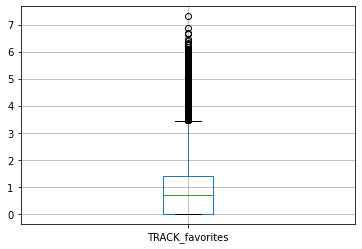

In [70]:
#df.boxplot(column='TRACK_favorites')

_, bp = df.boxplot(column='TRACK_favorites', return_type='both')



outliers = [flier.get_ydata() for flier in bp["fliers"]]
#df = df.drop( df[df["TRACK_favorites"] >= np.amin(outliers)].index )

len(outliers[0])

In [ ]:
#np.percentile(df.TRACK_favorites, 75)
#or i< np.percentile(df.TRACK_favorites, 25)
n=0;
outl_TRACK_favorites = np.ones((len(df.TRACK_favorites), 1), dtype=bool);
for i in df.TRACK_favorites:
    if i > np.percentile(df.TRACK_favorites, 75):
        outl_TRACK_favorites[n] = True;
        n=n+1;
    else:
        outl_TRACK_favorites[n] = False;
        n=n+1;

print(outl_TRACK_favorites)
outl_TRACK_favorites.sum()       
       

In [ ]:
df.boxplot(column='TRACK_interest')

In [9]:
np.percentile(df.TRACK_interest, 75)
n=0;
outl_TRACK_interest = np.ones((len(df.TRACK_interest), 1), dtype=bool);
for i in df.TRACK_interest:
    if i > np.percentile(df.TRACK_interest, 75) or i< np.percentile(df.TRACK_interest, 25):
        outl_TRACK_interest[n] = True;
        n=n+1;
    else:
        outl_TRACK_interest[n] = False;
        n=n+1;

print(outl_TRACK_interest)
        
       

KeyboardInterrupt: 

1026

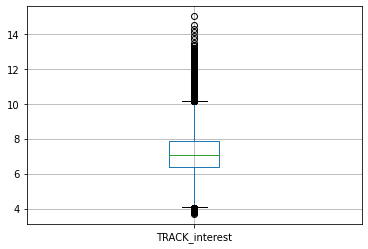

In [10]:
_, bp = df.boxplot(column='TRACK_interest', return_type='both')



outliers = [flier.get_ydata() for flier in bp["fliers"]]
#df = df.drop( df[df["TRACK_favorites"] >= np.amin(outliers)].index )

len(outliers[0])

In [ ]:
df.boxplot(column='TRACK_listens')

In [8]:
np.percentile(df.TRACK_listens, 75)
n=0;
outl_TRACK_listens = np.ones((len(df.TRACK_favorites), 1), dtype=bool);
for i in df.TRACK_listens:
    if i > np.percentile(df.TRACK_listens, 75) or i< np.percentile(df.TRACK_listens, 25):
        outl_TRACK_listens[n] = True;
        n=n+1;
    else:
        outl_TRACK_listens[n] = False;
        n=n+1;

print(outl_TRACK_listens)

KeyboardInterrupt: 

843

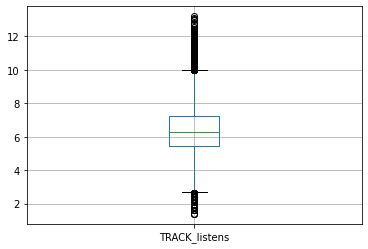

In [11]:
_, bp = df.boxplot(column='TRACK_listens', return_type='both')



outliers = [flier.get_ydata() for flier in bp["fliers"]]
#df = df.drop( df[df["TRACK_favorites"] >= np.amin(outliers)].index )

len(outliers[0])

In [ ]:
df.boxplot(column='TRACK_number')

In [ ]:
np.percentile(df.TRACK_number, 75)
n=0;
outl_TRACK_number = np.ones((len(df.TRACK_number), 1), dtype=bool);
for i in df.TRACK_number:
    if i > np.percentile(df.TRACK_number, 75) or i< np.percentile(df.TRACK_number, 25):
        outl_TRACK_number[n] = True;
        n=n+1;
    else:
        outl_TRACK_number[n] = False;
        n=n+1;

print(outl_TRACK_number)

954

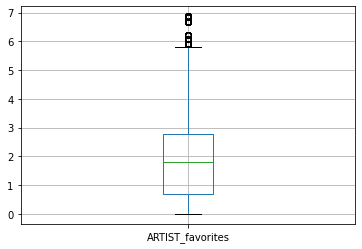

In [12]:
_, bp = df.boxplot(column='ARTIST_favorites', return_type='both')



outliers = [flier.get_ydata() for flier in bp["fliers"]]
#df = df.drop( df[df["TRACK_favorites"] >= np.amin(outliers)].index )

len(outliers[0])

In [ ]:
df.boxplot(column='ARTIST_favorites')

In [ ]:
np.percentile(df.ARTIST_favorites, 75)
n=0;
outl_ARTIST_favorites = np.ones((len(df.ARTIST_favorites), 1), dtype=bool);
for i in df.ARTIST_favorites:
    if i > np.percentile(df.ARTIST_favorites, 75) or i< np.percentile(df.ARTIST_favorites, 25):
        outl_ARTIST_favorites[n] = True;
        n=n+1;
    else:
        outl_ARTIST_favorites[n] = False;
        n=n+1;

print(outl_ARTIST_favorites)

In [ ]:
df.boxplot(column='ALBUM_favorites')

In [ ]:
np.percentile(df.ALBUM_favorites, 75)
n=0;
outl_ALBUM_favorites = np.ones((len(df.ALBUM_favorites), 1), dtype=bool);
for i in df.ALBUM_favorites:
    if i > np.percentile(df.ALBUM_favorites, 75) or i< np.percentile(df.ALBUM_favorites, 25):
        outl_ALBUM_favorites[n] = True;
        n=n+1;
    else:
        outl_ALBUM_favorites[n] = False;
        n=n+1;

print(outl_ALBUM_favorites)

3433

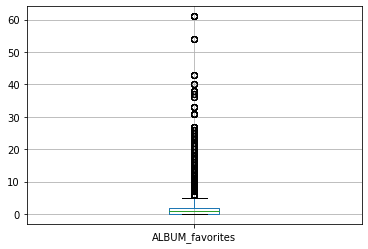

In [13]:
_, bp = df.boxplot(column='ALBUM_favorites', return_type='both')



outliers = [flier.get_ydata() for flier in bp["fliers"]]
#df = df.drop( df[df["TRACK_favorites"] >= np.amin(outliers)].index )

len(outliers[0])

In [ ]:
df.boxplot(column='ALBUM_tracks')

In [ ]:
np.percentile(df.ALBUM_tracks, 75)
n=0;
outl_ALBUM_tracks = np.ones((len(df.ALBUM_tracks), 1), dtype=bool);
for i in df.ALBUM_tracks:
    if i > np.percentile(df.ALBUM_tracks, 75) or i< np.percentile(df.ALBUM_tracks, 25):
        outl_ALBUM_tracks[n] = True;
        n=n+1;
    else:
        outl_ALBUM_tracks[n] = False;
        n=n+1;

print(outl_ALBUM_tracks)

5059

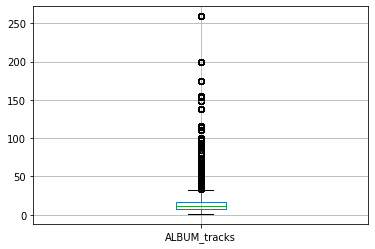

In [14]:
_, bp = df.boxplot(column='ALBUM_tracks', return_type='both')



outliers = [flier.get_ydata() for flier in bp["fliers"]]
#df = df.drop( df[df["TRACK_favorites"] >= np.amin(outliers)].index )

len(outliers[0])

In [ ]:
df.boxplot(column='ALBUM_date_released_year')

In [15]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=100, min_samples=4)
dbscan.fit(X)

In [ ]:
np.unique(dbscan.labels_, return_counts=True)

## LOF

In [16]:
from sklearn.neighbors import LocalOutlierFactor

In [17]:
clf = LocalOutlierFactor(n_neighbors=2)
outliers = clf.fit_predict(X)

In [18]:
clf.negative_outlier_factor_

array([-1.05938833, -0.98060718, -0.99515383, ..., -1.005267  ,
       -0.96876337, -0.92726594])

In [19]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 6618, 48699], dtype=int64))

In [20]:
np.where(outliers==-1)

(array([    3,     7,    16, ..., 55302, 55309, 55313], dtype=int64),)

In [21]:
clf.negative_outlier_factor_[np.where(outliers==-1)]

array([-2.56335495, -3.0317456 , -1.5261531 , ..., -2.8171642 ,
       -1.68001462, -3.42635957])

In [22]:
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.5000910957861053

In [23]:
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)])

-28.21166998500644

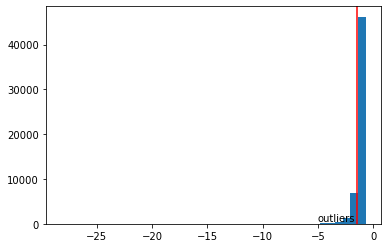

In [24]:
plt.hist(clf.negative_outlier_factor_, bins=40)
plt.axvline(-1.5, c='r')
plt.text(-5, 600, 'outliers')
plt.show()

In [55]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.auto_encoder import AutoEncoder

## ABOD

In [26]:
clf = ABOD()
clf.fit(X)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [27]:
clf.decision_scores_

array([  -2.39372013, -279.16834655,   -4.343817  , ...,   -2.78104349,
        -14.30092277,  -10.34870813])

In [28]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([49617,  5700], dtype=int64))

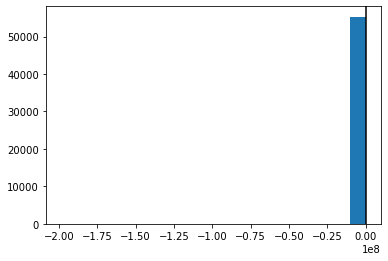

In [29]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

## KNN

In [30]:
clf = KNN()
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [31]:
clf.decision_scores_

array([0.84940054, 0.4802062 , 0.91319584, ..., 0.66129418, 0.9756062 ,
       0.61155994])

In [32]:
anomlay_score = clf.decision_function(X)

In [33]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([50681,  4636], dtype=int64))

In [34]:
np.mean(anomlay_score[np.where(outliers==1)])

2.497035213603581

In [35]:
np.mean(anomlay_score[np.where(outliers==0)])

0.6446599340012185

In [36]:
np.mean(clf.decision_scores_[np.where(outliers==1)])

2.7043812394552282

In [37]:
np.mean(clf.decision_scores_[np.where(outliers==0)])

0.7045139447224097

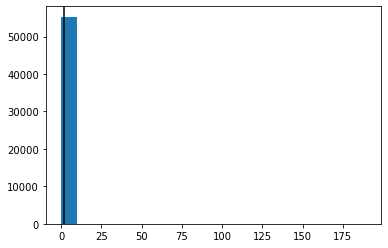

In [38]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

In [62]:
clf = AutoEncoder(epochs=10)

In [64]:
clf.fit(X)

outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

ValueError: The number of neurons should not exceed the number of features

In [63]:
anomlay_score = clf.decision_function(X)

NotFittedError: This AutoEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
outliers_proba = clf.predict_proba(X)

In [ ]:
plt.hist(outliers_proba, bins=20)
#plt.axvline(np.min(anomlay_score[np.where(outliers==1)]), c='k')
plt.show()

In [ ]:
plt.hist(anomlay_score, bins=20)
plt.axvline(np.min(anomlay_score[np.where(outliers==1)]), c='k')
plt.show()